In [1]:
import json
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, roc_curve
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.colors import ListedColormap

from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, BatchNormalization
from keras.optimizers import SGD, Adam, RMSprop
from keras.initializers import glorot_normal, Zeros, RandomNormal


Using TensorFlow backend.
/Users/omkarreddy/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/omkarreddy/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/omkarreddy/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/omkarreddy/opt/anacond

In [2]:
def get_one_hot_encoded_board_state(x, y):
    array = np.zeros((25, 25, 1))
    array[x][y] = 1
    
    return array
    
def get_model_data(file_path):
    X1_train = []
    X2_train = []
    Y_train = []
    
    print("Loading data...")
    try:
        with open(file_path) as json_file:
            json_data = json.load(json_file)
        for key, value in json_data.items():
            for index in range(len(value)):
                #array = np.array()
                array = np.array(value[index]['board_state'])
                #array = array/array.max()#normalize(array)
                array = np.reshape(array, (25, 25, 1))
                #array = array - array.mean()
                #array = array/array.std()
                X1_train.append(array) # change the shape of the array from 25x25 to  25x25x1
                Y_train.append(value[index]['move_quality'])
                array = np.zeros((25, 25, 1))
                array[value[index]['action']['x']][value[index]['action']['y']] = 1
                X2_train.append(array)
        
        print("Done")
    except Exception as e:
        print(e)
        
    X = pd.DataFrame({'X1':X1_train, 'X2':X2_train, 'Y':Y_train})
    X = shuffle(X)
    print(type(X["X1"][0]))
    print(X["X1"][0].shape)
    print("Done")
    X, Y_train = X[["X1", "X2"]], X["Y"]
    Y_train = (Y_train>0).astype(float)
    return X, list(Y_train)


def get_model_old():

    conv1 = Sequential()
    conv1.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(25,25,1)))
    conv1.add(MaxPooling2D((2,2)))
    conv1.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(25,25,1)))
    conv1.add(MaxPooling2D((2,2)))
    conv1.add(Flatten())
    
    conv2 = Sequential()
    conv2.add(Conv2D(8, kernel_size=3, activation='relu', input_shape=(25,25,1)))
    conv2.add(MaxPooling2D((2,2)))
    conv2.add(Flatten())
    
    final_model = concatenate([conv1, conv2])
    final_model.add(Dense(32, activation='relu'))
    final_model.add(Dense(1, activation='sigmoid'))
    final_model.compile(optimizer='sgd', loss='mean_squared_error', metrics=['accuracy'])
    
def get_model():

    input1 = Input(shape=(25, 25, 1))
    # conv1 = Conv2D(256, kernel_size=3, activation='relu', kernel_initializer=Zeros())(input1)
    # conv1 = MaxPooling2D((2,2))(conv1)
    conv1 = Conv2D(128, kernel_size=3, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None))(input1)
    conv1 = MaxPooling2D((2,2))(input1)
    conv1 = Conv2D(64, kernel_size=3, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None))(conv1)
    conv1 = MaxPooling2D((2,2))(conv1)
    conv1 = Conv2D(32, kernel_size=3, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None))(conv1)
    conv1 = MaxPooling2D((2,2))(conv1)
    conv1 = Flatten()(conv1)
    
    input2 = Input(shape=(25, 25, 1))
    conv2 = Flatten()(input2)
    
    final_model = concatenate([conv1, conv2])
    final_model = Dense(128, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None))(final_model)
    final_model = Dense(32, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None))(final_model)
    final_model = Dense(1, activation='sigmoid')(final_model)
    
    model = Model(inputs=[input1, input2], outputs=final_model)
    
    sgd = RMSprop(lr=0.0001)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['mae'])
    
    print(model.summary())
    return model
    

In [3]:
file_path = './experiments/moveData/experiment_0.3_new_heuristic_part1_moves.json'
X, Y = get_model_data(file_path)
file_path = './experiments/moveData/experiment_0.3_new_heuristic_part2_moves.json'
X2, Y2 = get_model_data(file_path)

X = pd.concat([X, X2], axis=0)
Y.extend(Y2)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5)

print(X_train.shape)
print(X_val.shape)

X1_train = np.reshape(X_train["X1"].tolist(), (X_train.shape[0], 25, 25, 1))
X2_train = np.reshape(X_train["X2"].tolist(), (X_train.shape[0], 25, 25, 1))
X1_val = np.reshape(X_val["X1"].tolist(), (X_val.shape[0], 25, 25, 1))
X2_val = np.reshape(X_val["X2"].tolist(), (X_val.shape[0], 25, 25, 1))

Loading data...


KeyboardInterrupt: 

In [ ]:
#print(type(X_train["X1"][0]))
#print(X_train["X1"][0].shape)
#print("Done")
model = get_model()
print(len([X1_train, X2_train]))
model.fit([X1_train, X2_train], Y_train, validation_data=([X1_val, X2_val], Y_val), epochs=70, batch_size=50)

In [ ]:
#print(X_test.shape)
X1_test = np.reshape(X_test["X1"].tolist(), (X_test.shape[0], 25, 25, 1))
X2_test = np.reshape(X_test["X2"].tolist(), (X_test.shape[0], 25, 25, 1))


train_predictions = model.predict([X1_train, X2_train])
final_predictions = []
for x in train_predictions:
    if x < 0.5:
        final_predictions.append(0)
    else:
        final_predictions.append(1)
print("Train Accuracy = "+str(np.mean(np.array(final_predictions) == np.array(Y_train))))

predictions = model.predict([X1_test, X2_test])
#print(predictions)

final_predictions = []
for x in predictions:
    if x < 0.5:
        final_predictions.append(0)
    else:
        final_predictions.append(1)
#print(final_predictions)
#print(Y_test)
print("Test Accuracy = "+str(np.mean(np.array(final_predictions) == np.array(Y_test))))
print(confusion_matrix(Y_test, final_predictions))
fpr, tpr, thresholds = roc_curve(Y_test, final_predictions)

plt.plot(fpr, tpr)

In [ ]:
print(pd.Series(Y).value_counts())

In [ ]:
#file = "/Users/omkarreddy/Desktop/RAWork/ProjectBlue/battle-perc-master/gym-percolation/models/iteration1/model_0.3_new.sav"
#pickle.dump(model, open(file, 'wb'))

In [ ]:
print(pd.Series(Y).value_counts())

## Model with stacked arrays

In [ ]:
def get_model_data_stacked(file_path):
    X1_train = []
    X2_train = []
    Y_train = []
    
    print("Loading data...")
    try:
        with open(file_path) as json_file:
            json_data = json.load(json_file)
        for key, value in json_data.items():
            for index in range(len(value)):
                array_board = np.array(value[index]['board_state'])
                array_board = np.reshape(array_board, (25, 25, 1))
                #X1_train.append(array)
                Y_train.append(value[index]['move_quality'])
                array_action = np.zeros((25, 25, 1))
                array_action[value[index]['action']['x']][value[index]['action']['y']] = 1
                #X2_train.append(array)
                stacked_array = np.dstack((array_board, array_action))
                X1_train.append(stacked_array)
        
        print("Done")
    except Exception as e:
        print(e)
        
    X = pd.DataFrame({'X':X1_train, 'Y':Y_train})
    X = shuffle(X)
    print(type(X["X"][0]))
    print(X["X"][0].shape)
    print("Done")
    X, Y_train = X["X"], X["Y"]
    Y_train = (Y_train>0).astype(float)
    return X, list(Y_train)

def get_model_stacked():

    input1 = Input(shape=(25, 25, 2))
    conv1 = Conv2D(256, kernel_size=3, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None))(input1)
    conv1 = MaxPooling2D((2,2))(input1)
    conv1 = Conv2D(128, kernel_size=3, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None))(conv1)
    conv1 = MaxPooling2D((2,2))(conv1)
    conv1 = Conv2D(64, kernel_size=3, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None))(conv1)
    conv1 = MaxPooling2D((2,2))(conv1)
    conv1 = Flatten()(conv1)
    
    #final_model = concatenate([conv1, conv2])
    final_model = Dense(128, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None))(conv1)
    final_model = Dense(32, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None))(final_model)
    final_model = Dense(1, activation='sigmoid')(final_model)
    
    model = Model(inputs=input1, outputs=final_model)
    
    sgd = Adam(lr=0.0001)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    
    print(model.summary())
    return model

In [ ]:
file_path = './experiments/moveData/iteration4/experiment_0.3_new_heuristic_part1.json'
X, Y = get_model_data_stacked(file_path)
file_path = './experiments/moveData/iteration4/experiment_0.3_new_heuristic_part2.json'
X2, Y2 = get_model_data_stacked(file_path)

X = pd.concat([X, X2], axis=0)
Y.extend(Y2)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5)

print(X_train.shape)
print(X_val.shape)

# X1_train = np.reshape(X_train["X1"].tolist(), (30679, 25, 25, 1))
# X2_train = np.reshape(X_train["X2"].tolist(), (30679, 25, 25, 1))
# X1_val = np.reshape(X_val["X1"].tolist(), (6574, 25, 25, 1))
# X2_val = np.reshape(X_val["X2"].tolist(), (6574, 25, 25, 1))

X_train = np.reshape(X_train.tolist(), (X_train.shape[0], 25, 25, 2))
#X2_train = np.reshape(X_train["X2"].tolist(), (35062, 25, 25, 2))
X_val = np.reshape(X_val.tolist(), (X_val.shape[0], 25, 25, 2))
#X2_val = np.reshape(X_val["X2"].tolist(), (4383, 25, 25, 1))

In [ ]:
model = get_model_stacked()
#print(len([X1_train, X2_train]))
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=70, batch_size=50)

In [ ]:
print(X_test.shape)
X1_test = np.reshape(X_test.tolist(), (X_test.shape[0], 25, 25, 2))
#X2_test = np.reshape(X_test["X2"].tolist(), (4383, 25, 25, 1))

train_predictions = model.predict(X_train)

final_predictions = []
for x in train_predictions:
    if x < 0.5:
        final_predictions.append(0)
    else:
        final_predictions.append(1)

predictions = model.predict(X1_test)

#print(predictions)

final_predictions = []
for x in predictions:
    if x < 0.5:
        final_predictions.append(0)
    else:
        final_predictions.append(1)
#print(final_predictions)
#print(Y_test)
print(np.mean(np.array(final_predictions) == np.array(Y_test)))
print(confusion_matrix(Y_test, final_predictions))
fpr, tpr, thresholds = roc_curve(Y_test, final_predictions)
print(fpr)
print(tpr)

plt.plot(fpr, tpr)

In [ ]:
file = "./models/iteration4/model_0.3_stacked_heuristic.sav"
pickle.dump(model, open(file, 'wb'))

In [ ]:
file_path = './experiments/moveData/experiment_0.3.json'
X, Y = get_model_data(file_path)

for index in range(len(X["X1"])):
    
    observation = X["X1"].iloc[index]

    #["black", "orange", "blue", "green"] 
    flatui = ["black", "tomato", "deepskyblue", "darkseagreen"]
    #flatui = 
    sns.set_palette(flatui)
    new_cmap = ListedColormap(flatui)
    heat_map = sns.heatmap(np.reshape(observation, (25,25)), cmap=new_cmap)
    heat_map.show()

In [ ]:
for state in data["0"]:
    fig = plt.figure(figsize=(5,5))
    plt.imshow(state['board_state'], origin='lower')
    for a in state['action_space']:
        plt.plot(a['x'], a['y'], 'bx')
    plt.plot(state['action']['y'], state['action']['x'], 'ro')
    plt.show()

Loading data...


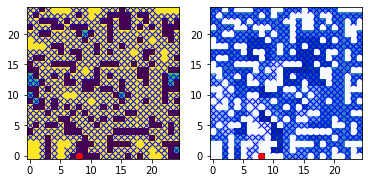

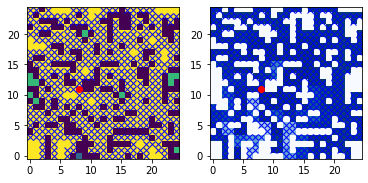

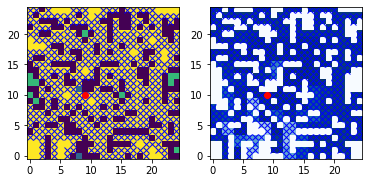

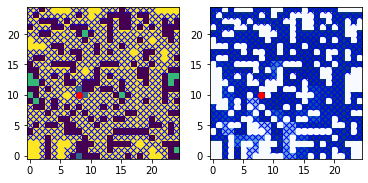

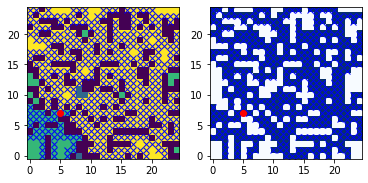

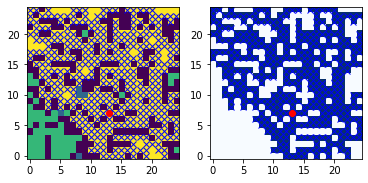

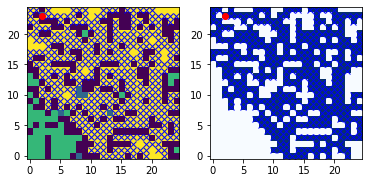

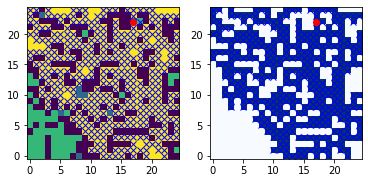

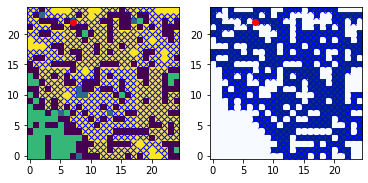

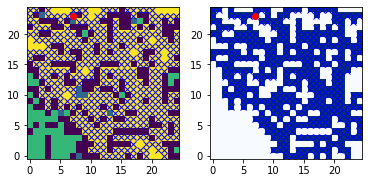

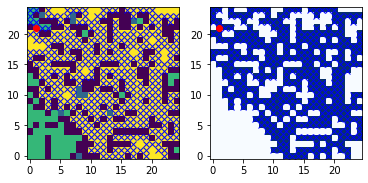

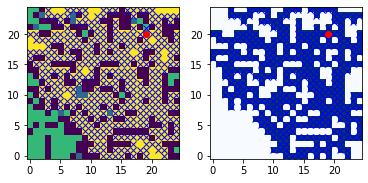

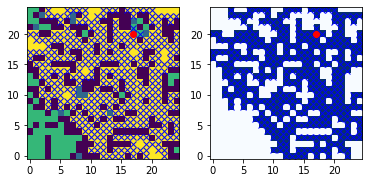

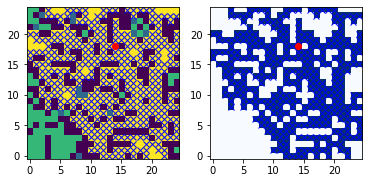

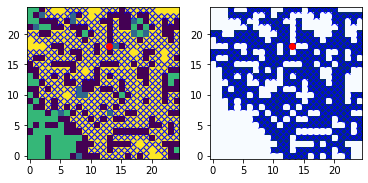

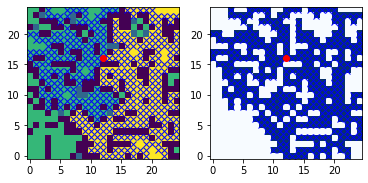

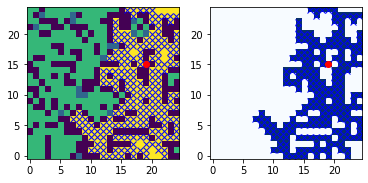

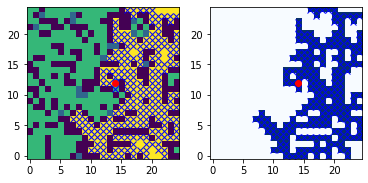

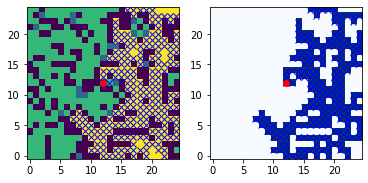

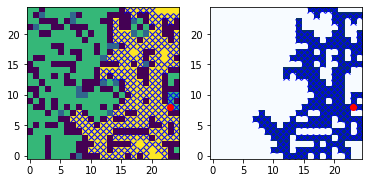

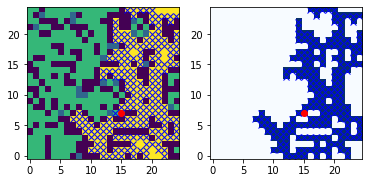

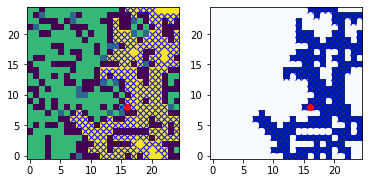

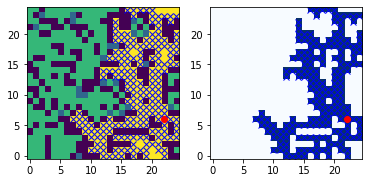

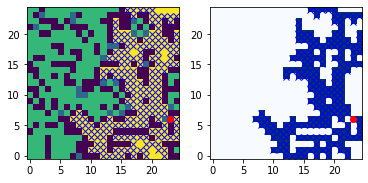

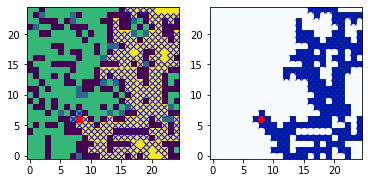

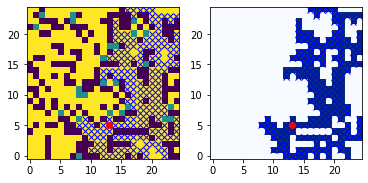

Done


In [12]:
def plot_data(file_path):
    X1_train = []
    X2_train = []
    Y_train = []
    
    x_list = []
    
    print("Loading data...")
    try:
        with open(file_path) as json_file:
            json_data = json.load(json_file)
        for key, value in json_data.items():
            for index in range(len(value)):
                fig, axes = plt.subplots(1, 2)#,figsize=(10,5))
                axes[0].imshow(value[index]['board_state'], origin='lower')
                array = np.zeros((25,25))
                for a in value[index]['action_space']:
                    axes[0].plot(a['y'], a['x'], 'bx')
                    axes[1].plot(a['y'], a['x'], 'bx')
                    array[a['x']][a['y']] = a['prob']
                axes[1].imshow(array, cmap='Blues', origin='lower')
                axes[0].plot(value[index]['action']['y'], value[index]['action']['x'], 'ro')
                axes[1].plot(value[index]['action']['y'], value[index]['action']['x'], 'ro')
                plt.show()
            break
        
        print("Done")
    except Exception as e:
        print(e)
        
file_path = './experiments/moveData/iteration2/experiment_0.3_new_heuristic_small.json'
plot_data(file_path)

In [ ]:
from sklearn.linear_model import Perceptron

df = pd.DataFrame([[-1, 0, -1],[1, 0, -1],[0, -1, 1],[0, 1, 1]], columns=['x1', 'x2', 'y'])

model = Perceptron()
model.fit(df[['x1','x2']], df['y'])
model.coef_
model.intercept_


In [ ]:
random = [69.91, 64.74, 64.17, 65.74]
iter1 = [69.11, 65.54, 68.34, 65.47]
iter2 = [61.56, 60.97, 65.31, 65.0]
iter3 = [62.81, 60.09, 59.91, 65.2]
iter4 = [65.22, 68.39, 65.75, 62.45]

#data = np.vstack((random, iter1))
data = pd.DataFrame([random, iter1, iter2, iter3, iter4], columns=["a", "b", "c", "d"])

In [ ]:
#data = pd.DataFrame([[1, 2], [3, 4], [5, 6]], columns=["a", "b"])
x = range(1,5)

fig1, ax1 = plt.subplots()
plt.boxplot(data)
plt.xticks(x, ('rand', 'CNN 1', 'CNN 2', 'CNN 3', 'CNN4'))

In [ ]:
x = range(0,5)

for index in range(0,5):
    array = np.array([index]*4)
    plt.scatter(array, data.iloc[index, :])
    
plt.xticks(x, ('rand', 'CNN 1', 'CNN 2', 'CNN 3', 'CNN4'))